# Introduction to Bayesian Inference
in this jupyter notebook our goal is to present the basic of bayesian inference and to see how we can apply it to different situations. This notebook contains a small introduction to bayesian inference, however I still have a lot to learn in the field so this presentation is also, for me, to make sure that I understood the principles

## Bayesian statistics 
Bayesian statiscs aims at computing the probability of differents parameters at the light of some observation: we mesure the impact of observed data on our assumptions concerning these parameters

Bayesian statistics are relying mostly on the Bayes formula:
$$ 
P(A|B)=\frac{P(B|A)P(A)}{P(B)}
$$
This formula means that observing the effect of A on B can give us some information on the probability of A if we know the possibilities of A and B.

If you are confused (I was definitly confused at this moment) here is an example from wikipedia (french page) that I suggest we resolve:

### Laplace: sex ratio in population

Laplace observe in year 1785 a discrepancy between the birth of boys and girls, respectively $N_1 = 251 527$ and $N_2=241 945$ . He want to determine if the this difference is showing some biased probability $\theta$ of having a boy.

Assuming nothing on $\theta$ (ie $\theta$ follows a uniform law between 0 and 1) he want to compute

$$
P(\theta \leq \frac{1}{2}|(N_1,N_2))
$$

Using Bayes formula:
$$
P(\theta|(N_1,N_2))=\frac{P((N_1,N_2)|\theta)P(\theta)}{P((N_1,N_2))}
$$

Ok so the easiest term in the previous equation is $P(\theta)$ as we assumed $\theta$ to follow a uniform law between 0 and 1 therefore $P(\theta)=\frac{1}{1-0}=1$

$P((N_1,N_2)|\theta)$ is $N_1$ draws with probability $\theta$  and $N_2$ draws with probability $(1-\theta)$ therefore:
$$
P((N_1,N_2)|\theta)=\theta^{N_1}(1-\theta)^{N_2}
$$

$P((N_1,N_2))$ is equal to $P((N_1,N_2)|\theta)$ summed over all possible values of $\theta$:

$$
P((N_1,N_2))=\int_0^1 P((N_1,N_2)|\theta)d\theta = \int_0^1 \theta^{N_1}(1-\theta)^{N_2} d\theta = B(N_1+1,N_2+1)
$$

With B the [beta function](https://en.wikipedia.org/wiki/Beta_function)

In the end we have:

$$
P(\theta|(N_1,N_2))=\frac{\theta^{N_1}(1-\theta)^{N_2}}{B(N_1+1,N_2+1)}
$$

by definition:

$$
P(\theta \leq \frac{1}{2}|(N_1,N_2))= \int_0^{\frac{1}{2}} P(\theta|(N_1,N_2))d\theta =  \frac{\int_0^{\frac{1}{2}}\theta^{N_1}(1-\theta)^{N_2}d\theta}{B(N_1+1,N_2+1)}= I_{\frac{1}{2}}(N_1+1,N_2+1)
$$

with $I_x(a,b)$ being the [regularized incomplete beta function](https://en.wikipedia.org/wiki/Beta_function#Incomplete_beta_function)

Lucky for us this regularized incomplete beta function is implemented in scipy












In [1]:
# the function betainc here is not the incomplete beta function but the regularized incomplete beta function
# check out the docs of scipy: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.special.betainc.html
# it is normalised using the beta function in the form of a gamma function ratio
from scipy.special import betainc
N1 = 251527
N2 = 241945
x = 0.5
betainc(N1+1,N2+1,x)

1.1460584897220391e-42

The probability of having a proportion of birth of boys inferior to 0.5 is equal to $1.15 \times 10^{-42}$ in the light of such observation. We can call it unlikely

## Bayesian inference
In Machine learning we are often facing the problem of finding the "best" set of parameters of a parametric function to minimize the Mean Square Error however this set of parameter can not be the optimum that is the most robust. Let $\theta \in \mathbb R^N$ the vector of parameters that we would like to find, $(X,Y)=D$ our data.
We would like to have the following quantity:
$$
P(\theta|D)
$$
Meaning the probability of our parameters once we observed the data.


Using Bayes formula:
$$
P(\theta|D)=\frac{P(D|\theta)P(\theta)}{P(D)}
$$

$P(D|\theta)$ is the likelyhood of the data, $P(\theta)$ is our prior belief of the values of the parameters and $P(D)$ is the likelyhood summed over all the parameters

Of course if $N=2$ the integral denominator is quite easy, however the integral becomes much more dificult in the case of a higly dimentional $\theta$ however the denominator is a constant of theta therefore we can write:

$$
P(\theta|D) \propto P(D|\theta)P(\theta)
$$

And you'll see: that's just about what we need!


## Metropolis Hastings algorithm
The [Metropolis Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) Monte Carlo Markov Chain method to sample from a probability distribution from which direct sampling is difficult.
Let $P : \mathbb R^n \rightarrow \mathbb R$ be the distribution that we want to sample however we don't have acces to $P$ but a function $f : \mathbb R^n \rightarrow \mathbb R$ that is proportionate to $P$: 
$$
P(x) \propto f(x)
$$
We need also a transition distribution $g:\mathbb R^n \times \mathbb R^n \rightarrow \mathbb R$ that tells us how we can pass from a postion $x$ to a position $x'$, a classical choice of $g$ is a gaussian perturbation around $x$. We will consider the case of $g$ being symetric it will simplify the steps of the algorithm.

The algorithm works this way:
* Initialisation: initialize $x_0 \in \mathbb R^n $
* Sample $x' \sim g(.|x)$ 
* Compute $ \alpha = \frac{P(x')}{P(x_t)}= \frac{f(x')}{f(x_t)}$
* with probability $p = min(1,\alpha)$: $x_{t+1} \leftarrow x'$ otherwise $x_{t+1}=x_t$

After a certain number of step $x_t$ follows the probability distribution $P$

The number of steps depends on the dimension $n$, of the function $g$. THere are lots of heuristics that allow to know if the MCMC converged.

We will take simple examples, the computation won't take long and we will perform a lot of iterations to make sure that we converged to the distribution $P$



In [4]:
# Simple case where we sample a sum of two gaussian distribution
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

# Sum of two gaussian distributions
def pdf(x):
    return  1/math.sqrt(2*math.pi)*math.exp(-0.5*(x-2)**2) + 1/math.sqrt(2*math.pi)*math.exp(-0.5*(x+1)**2)

# transition function
def step_dist(x,sigma=0.2):
    return x+ sigma*np.random.randn(1)

# metropolis hasting algorithm
def metropolis_hastings(number_of_steps,x0,pdf):
    x=x0
    for step in range(number_of_steps):
        #sampling new state
        x_test =  step_dist(x)
        #computing alpha
        alpha = pdf(x_test)/pdf(x)
        #if ap
        if alpha >=1:
            x = x_test
        else:
            if  random.random() < alpha:
                x = x_test
    return x[0]

def run_mcmc():
    number_of_steps=2000
    number_of_sample=1000
    #initialisation at 0.5
    x0 = 0.5
    #running the algorithm  multiple times
    results = [metropolis_hastings(number_of_steps,x0,pdf) for _ in tqdm(range(number_of_sample))]
    plt.hist(results,bins=50)
    plt.show()

100%|██████████| 1000/1000 [01:43<00:00,  9.57it/s]


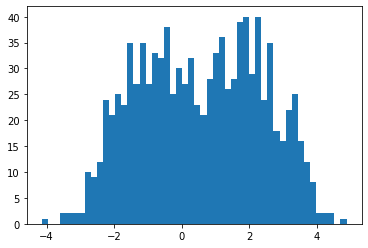

In [5]:
run_mcmc()

## Application to Bayesian inference
We will apply the metropolis algorithm to compute the posterior distribition:

Remember that we had the following relation:
$$
P(\theta|D) \propto P(D|\theta)P(\theta)
$$
This time we will apply the algorithm to $\theta$, the function $f(\theta)=P(D|\theta)P(\theta)$

We can compute $f$ as $P(D|\theta)$ is the likelihood of the data , $P(\theta)$  is the prior that we gave to our parameters

The likelihood depends on the problem that we consider: for regression or classification the computation is different, I will present here the case of regression




In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

class linearModel():
    def __init__(self,mu,sigma,dim):
        self.mu = np.ones(dim)*mu
        self.sigma = np.ones(dim)*sigma
        self.mu_bias = mu
        self.sigma_bias = sigma
        self.dim = dim
    def forward(self,X,w_sampled,bias_sampled):
        return np.dot(X,w_sampled)+bias_sampled

    #probability of the weights following a normal prior
    def proba_weights(self,w_sampled,bias_sampled):
        prob_w = np.prod((1/math.sqrt(2*math.pi)/self.sigma)*np.exp(-.5*(w_sampled-self.mu)**2/self.sigma))
        prob_b = (1/math.sqrt(2*math.pi)/self.sigma_bias)*np.exp(-.5*(bias_sampled-self.mu_bias)**2/self.sigma_bias)
        return prob_b*prob_w
    #probability of Y knowing the weights and biases
    def proba_y(self,X,w_sampled,bias_sampled,Y,noise):
        y_hat = self.forward(X,w_sampled,bias_sampled)
        proba_y = np.prod((1/math.sqrt(2*math.pi)/noise)*np.exp(-.5*(y_hat-Y)**2/noise))
        return proba_y

    #probability of the weights knowing the input data
    def bayesian_proba(self,X,w_sampled,bias_sampled,Y,noise):
        return self.proba_weights(w_sampled,bias_sampled)*self.proba_y(X,w_sampled,bias_sampled,Y,noise)

#step function that we picked to be symetric
def step_dist(sigma=0.15,shape=1):
    return sigma*np.random.randn(shape)

#Sampling the posterior using metropolis hastings
def metropolis_hastings(number_of_steps,w0,b0,model,X,Y,noise):
    #initializing
    w=w0
    b=b0
    #looping for number of iteration: here is the MCMC 
    for step in range(number_of_steps):
        # Building new test vector
        w_test = w + step_dist(shape=model.dim)
        b_test = b + step_dist()
        #computing alpha
        alpha = model.bayesian_proba(X,w_test,b_test,Y,noise)/model.bayesian_proba(X,w,b,Y,noise)
        if alpha >=1:
            w = w_test
            b = b_test
        else:
            if  random.random() < alpha:
                w = w_test
                b = b_test
    return w.tolist(),b[0]

def run_linear_mcmc():
    # number of steps of the MCMC
    number_of_steps=2000
    # number of sample of the MCMC
    number_of_sample=1500
    # Size of the dataset
    size_batch = 100
    # Dimension of the intput X
    dim = 2
    # Noise variance that we will add to the output
    noise = 0.1
    linear = linearModel(0,1,dim)
    # Building toy dataset
    X = np.random.rand(size_batch,dim)*2 -1
    #Selecting random values that will have to be found by the linear model
    W = np.random.randn(dim)
    B = np.random.randn(1)
    #computing noisy output that we will try to approximate
    Y = np.dot(X,W) + B + np.random.randn(size_batch)*noise
    print("Parameters to guess:")
    print("W:",W)
    print("B: ",B)
    print("_____________________")
    #initialization at 0 for all parameters
    w0 = np.zeros(dim)
    b0 = np.zeros(1)

    # sampling from the posterior
    w,b = zip(*[metropolis_hastings(number_of_steps,w0,b0,linear,X,Y,noise) for _ in tqdm(range(number_of_sample))])
    unzipped_w = zip(*w)
    i=0
    #printing average of the posterior
    print("Average parameters:")
    print("W: ",[np.mean(ws) for ws in unzipped_w])
    print("B: ",np.mean(b))
    #plots
    for w_single in unzipped_w:
        plt.figure()
        plt.hist(w_single,bins=40)
        plt.title("w"+str(i))
        i += 1
    plt.figure()
    plt.hist(b,bins=40)
    plt.title("b")


  0%|          | 0/1500 [00:00<?, ?it/s]

Parameters to guess:
W: [ 0.66472588 -0.06998935]
B:  [0.0735572]
_____________________


100%|██████████| 1500/1500 [13:36<00:00,  1.93it/s]


Average parameters:
W:  [0.6696426454030919, -0.059652492554884855]
B:  0.09262194689561934


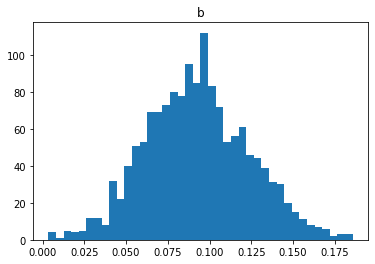

In [9]:
run_linear_mcmc()

These result are great but this is definitly taking too long I will present here quick solutions for speeding up the sampling the posterior

## Burn - in, Acceptance rate
Between each iterations we reset the value to our $x_0$ however it is not the best strategy: it takes some time for $x$ to find the right set of parameters, what if we were to initialize the new MCMC at the end of the previously chain: the point already belongs to the posterior distribution, we just have to wait some iterations so as to decorrelate $x_0$ and $x_t$.

For now we chose abritrarily the step size of our transition however some heuristics exists: the acceptance rate is the average percentage of times that we accept the new value in the Metropolis algorithm. If it is close to 0 it means that $\alpha$ is always too small: the step brings $x$ to much less probable regions: the step is too big. On the other hand an acceptance rate too high means the step size is too big. Generally we try to have an acceptance rate of 0.4. Some more finely tuned Metropolis algorithms change the step size according to the acceptance rate.